In [7]:
import sys
sys.path.append("../../")

import torch
import torchvision.utils
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch import optim
from torch.utils.data import DataLoader
from torchvision import models
from torchsummary import summary

import numpy as np
import cv2

import src.neuralNetworksArch.BstCnn as bst
import src.utils.Visual as vis
import src.utils.DatasetLoader as dsetLoader
import src.utils.LossFunction as lossFunc

from src.config.Param import *

In [8]:
MODEL_PATH = '../../models/re-id.pth'
DATATEST_PATH = '../../dataset/cuhk02/datatest.csv'
IMAGES_PATH = '../../dataset/cuhk02/images/full/'

In [9]:
trans = transforms.Compose([transforms.ToTensor()])
test_dataset = dsetLoader.ContrastiveDataset(csv_path=DATATEST_PATH, images_path=IMAGES_PATH, transform=trans)

test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [10]:
model  = bst.BstCnn()
model.load_state_dict(torch.load(MODEL_PATH, map_location=Param.device))
model.eval()

RuntimeError: Error(s) in loading state_dict for BstCnn:
	Missing key(s) in state_dict: "fc.3.weight", "fc.3.bias", "fc.6.weight", "fc.6.bias", "fc.9.weight", "fc.9.bias". 
	Unexpected key(s) in state_dict: "fc.2.weight", "fc.2.bias", "fc.4.weight", "fc.4.bias". 
	size mismatch for fc.0.weight: copying a param with shape torch.Size([4096, 8192]) from checkpoint, the shape in current model is torch.Size([4096, 1024]).

### Parameter Summary

In [5]:
summary(model, [(3, 128, 64), (3, 128, 64)])

### Pengujian menggunakan citra dengan resolusi yang sama dengan resolusi dataset
Threshold yang digunakan adalah 0.5. Jika nilai dissimilarity <= 0.5 maka citra memuat objek yang sama begitupun sebaliknya.

In [6]:
dataiter = iter(test_dataloader)
with torch.no_grad():
    for i in range(len(test_dataloader)):
        img1, img2, label = next(dataiter)
        concatenated = torch.cat((img1, img2),0)

        img1 = img1.to(Param.device)
        print(img1)
        img2 = img2.to(Param.device)
        label = label.to(Param.device)
        
        out1, out2 = model(img1, img2)
        euclidean_distance = F.pairwise_distance(out1, out2)
        d = float(euclidean_distance.item())
        d = abs((1 / (1 + d)) - 1)
        
        if(i % 2 == 0):
            print('Dissimilarity', d)
            vis.imshow(torchvision.utils.make_grid(concatenated))

masuk ke sini
tensor([[[[0.1529, 0.1412, 0.1686,  ..., 0.4549, 0.3490, 0.0118],
          [0.1569, 0.1451, 0.1647,  ..., 0.7451, 0.4863, 0.0157],
          [0.1608, 0.1490, 0.1647,  ..., 0.9490, 0.4824, 0.0078],
          ...,
          [0.3490, 0.3922, 0.4196,  ..., 0.3255, 0.3647, 0.3647],
          [0.4431, 0.4314, 0.4235,  ..., 0.4863, 0.4784, 0.4706],
          [0.3608, 0.3373, 0.3294,  ..., 0.5216, 0.4980, 0.4392]],

         [[0.1529, 0.1451, 0.1686,  ..., 0.4588, 0.3529, 0.0118],
          [0.1569, 0.1490, 0.1647,  ..., 0.7490, 0.4902, 0.0157],
          [0.1608, 0.1490, 0.1686,  ..., 0.9529, 0.4824, 0.0078],
          ...,
          [0.4078, 0.4471, 0.4745,  ..., 0.3725, 0.4157, 0.4118],
          [0.4980, 0.4902, 0.4824,  ..., 0.5333, 0.5255, 0.5176],
          [0.4157, 0.3961, 0.3843,  ..., 0.5686, 0.5451, 0.4863]],

         [[0.1451, 0.1333, 0.1608,  ..., 0.4471, 0.3451, 0.0157],
          [0.1490, 0.1373, 0.1569,  ..., 0.7333, 0.4824, 0.0157],
          [0.1529, 0.1412, 0

NameError: name 'model' is not defined

### Test dengan pasangan gambar yang di-resize dan padding agar tidak terjadi distorsi pada objek

In [15]:
img1 = cv2.imread('../../dataset/testing/img1.png')
img2 = cv2.imread('../../dataset/testing/img2.png')

# img1 = cv2.resize(img1, (60,160))
# img2 = cv2.resize(img2, (60,160))

single_pair_datset = dsetLoader.SinglePairDataset(img1=img1, img2=img2, width=60, height=160, transform=trans)
single_pair_dataloader = DataLoader(single_pair_datset, batch_size=1, shuffle=False)

Dissimilarity 0.5387798234646627


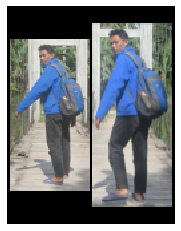

In [16]:
single_pair_dataiter = iter(single_pair_dataloader)
with torch.no_grad():
    img1, img2 = next(single_pair_dataiter)
    concatenated = torch.cat((img1, img2),0)

    img1 = img1.to(Param.device)
    img2 = img2.to(Param.device)

    out1, out2 = model(img1, img2)
    euclidean_distance = F.pairwise_distance(out1, out2)
    d = float(euclidean_distance.item())
    d = abs((1 / (1 + d)) - 1)

    print('Dissimilarity', d)
    vis.imshow(torchvision.utils.make_grid(concatenated))

### Test dengan pasangan gambar yang hanya di-resize sehingga terjadi distorsi pada objek

In [23]:
img1 = cv2.imread('../../dataset/testing/img1.png')
img2 = cv2.imread('../../dataset/testing/img2.png')

img1 = cv2.resize(img1, (64,128))
img2 = cv2.resize(img2, (64,128))

single_pair_datset = dsetLoader.SinglePairDataset(img1=img1, img2=img2, width=64, height=128, transform=trans)
single_pair_dataloader = DataLoader(single_pair_datset, batch_size=1, shuffle=False)

Dissimilarity 0.5251953403915315


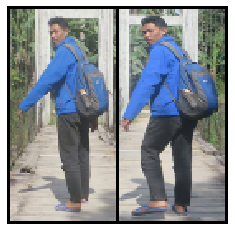

In [24]:
single_pair_dataiter = iter(single_pair_dataloader)
with torch.no_grad():
    img1, img2 = next(single_pair_dataiter)
    concatenated = torch.cat((img1, img2),0)

    img1 = img1.to(Param.device)
    img2 = img2.to(Param.device)

    out1, out2 = model(img1, img2)
    euclidean_distance = F.pairwise_distance(out1, out2)
    d = float(euclidean_distance.item())
    d = abs((1 / (1 + d)) - 1)

    print('Dissimilarity', d)
    vis.imshow(torchvision.utils.make_grid(concatenated))

### Kesimpulan :
Citra dengan distorsi justru memberikan hasil yang lebih baik karena tidak terdapat blank spot pada citra.